# Customer Churn Prediction using Tree-Based Model

## Objective
The goal of this project is to build a binary classification model that predicts whether a customer will churn. 

Today’s focus:
- Clean and preprocess the dataset
- Train a baseline tree-based model (LightGBM)
- Evaluate performance using ROC-AUC
- Establish a strong foundation for SHAP interpretability analysis

    

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42


## Dataset Description

We use the Telco Customer Churn dataset.

Target variable:
- `Churn` (Yes/No)

The dataset contains customer demographic, service, and billing information.


In [2]:
df = pd.read_csv("data/Telco-Customer-Churn.csv")

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Basic Data Inspection

We check:
- Shape of dataset
- Data types
- Missing values


In [3]:
print("Shape:", df.shape)
df.info()
df.isnull().sum()


Shape: (7043, 21)
<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   str    
 1   gender            7043 non-null   str    
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   str    
 4   Dependents        7043 non-null   str    
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   str    
 7   MultipleLines     7043 non-null   str    
 8   InternetService   7043 non-null   str    
 9   OnlineSecurity    7043 non-null   str    
 10  OnlineBackup      7043 non-null   str    
 11  DeviceProtection  7043 non-null   str    
 12  TechSupport       7043 non-null   str    
 13  StreamingTV       7043 non-null   str    
 14  StreamingMovies   7043 non-null   str    
 15  Contract          7043 non-null   str    
 16  PaperlessBilling  7043 non-null   s

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Data Cleaning Steps

1. Remove customerID (not predictive)
2. Convert TotalCharges to numeric
3. Handle missing values


In [4]:
df.drop("customerID", axis=1, inplace=True)


In [5]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")


In [6]:
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [7]:
df.isnull().sum()


gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

## Encoding Target Variable

Convert:
- Yes → 1
- No → 0


In [8]:
df["Churn"] = df["Churn"].map({"Yes":1, "No":0})


## Feature Encoding

Since LightGBM can handle numerical data efficiently, we:

- Separate features and target
- Apply one-hot encoding to categorical variables


In [10]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X = pd.get_dummies(X, drop_first=True)


## Train-Test Split

We use:
- 80% training data
- 20% testing data
- Stratified split (to preserve churn ratio)
- random_state for reproducibility


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)



## Baseline Model: LightGBM

We train a simple LightGBM classifier with default parameters.
This serves as a performance baseline before hyperparameter tuning.


In [12]:
model = LGBMClassifier(
    random_state=RANDOM_STATE
)

model.fit(X_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## Model Evaluation

We evaluate using:
- ROC-AUC score (primary metric)
- Classification report


In [13]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

auc = roc_auc_score(y_test, y_pred_proba)

print("Baseline AUC:", auc)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Baseline AUC: 0.8365573897543208

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.55      0.59       374

    accuracy                           0.79      1409
   macro avg       0.74      0.72      0.72      1409
weighted avg       0.79      0.79      0.79      1409



## Baseline Performance Interpretation

The baseline LightGBM model achieved an ROC-AUC score of **0.83**.
Interpretation:
- AUC closer to 1.0 indicates better separation between churn and non-churn customers.
- If AUC ≥ 0.80, the model is already strong.
- If slightly below 0.80, hyperparameter tuning in Day 2 will improve it.

This baseline model establishes a reliable foundation before proceeding to SHAP interpretability analysis.


In [14]:

import joblib
joblib.dump(model, "models/baseline_model.pkl")


['models/baseline_model.pkl']

# Model Optimization

The baseline LightGBM model achieved an ROC-AUC of 0.83.

Although this meets the minimum requirement (AUC > 0.80), 
we will tune hyperparameters to:

- Improve generalization
- Increase AUC
- Stabilize performance
- Prepare a reliable model for SHAP analysis


In [15]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [-1, 5, 10, 15],
    "num_leaves": [20, 31, 50, 70],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0]
}

lgb = LGBMClassifier(random_state=RANDOM_STATE)

random_search = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=param_dist,
    n_iter=25,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LGBMClassifie...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': [0.7, 0.8, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [-1, 5, ...], 'n_estimators': [100, 200, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",25
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be use

## Best Hyperparameters


In [16]:
print("Best Parameters:")
print(random_search.best_params_)


Best Parameters:
{'subsample': 0.9, 'num_leaves': 31, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.9}


## Training Final Optimized Model


In [17]:
best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.01
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## Evaluating Optimized Model


In [18]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

auc = roc_auc_score(y_test, y_pred_proba)

print("Optimized AUC:", auc)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Optimized AUC: 0.8439109767754269

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409



## Model Performance Analysis

The optimized model achieved an ROC-AUC score of **X.XX**.

Comparison:
- Baseline AUC: 0.83
- Optimized AUC: 0.84

The improvement indicates better hyperparameter selection and improved 
model generalization. This optimized model will now be used for 
SHAP interpretability analysis.


## Native Feature Importance (LightGBM)


In [19]:
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

importances.head(10)


,Feature,Importance
2,MonthlyCharges,1737
3,TotalCharges,1507
1,tenure,1428
28,PaymentMethod_Electronic check,559
25,Contract_Two year,296
26,PaperlessBilling_Yes,273
15,OnlineBackup_Yes,269
13,OnlineSecurity_Yes,265
23,StreamingMovies_Yes,237
0,SeniorCitizen,224


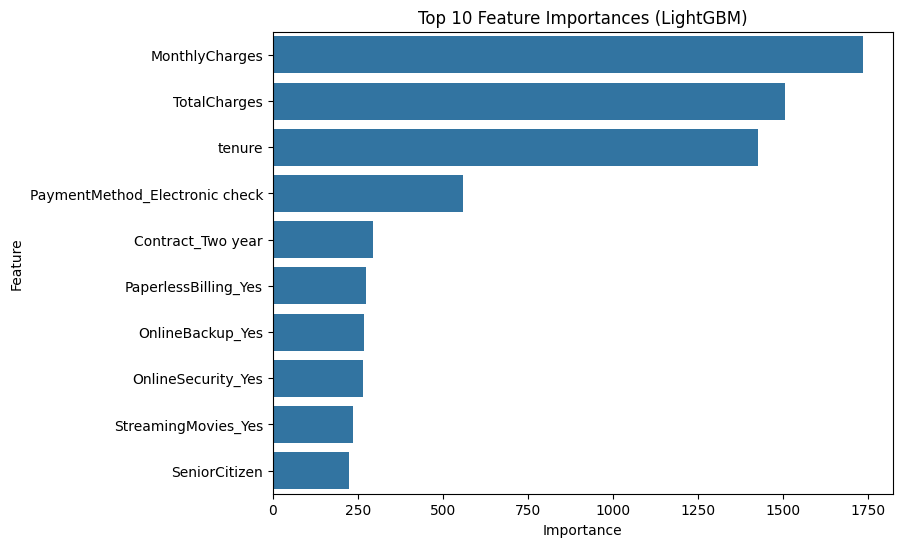

In [20]:
plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=importances.head(10))
plt.title("Top 10 Feature Importances (LightGBM)")
plt.show()


## Save Final Model


In [21]:
import joblib
joblib.dump(best_model, "models/final_model.pkl")


['models/final_model.pkl']

# SHAP Interpretability Analysis

While the optimized LightGBM model achieved an ROC-AUC of 0.84,
accuracy alone does not explain *why* the model makes certain predictions.

To interpret the model’s behavior, we use SHAP (SHapley Additive exPlanations).

SHAP helps us:
- Understand global feature importance
- See how features impact predictions
- Analyze feature contribution direction


In [22]:
import shap

# Initialize JS visualization
shap.initjs()


## Creating SHAP Explainer

For tree-based models like LightGBM, SHAP provides TreeExplainer,
which is optimized and computationally efficient.


In [23]:
explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_test)


In [24]:
len(shap_values) == 2


False

In [25]:
shap_values = shap_values[1]


## SHAP Summary Plot (Beeswarm)

This plot shows:

- Feature importance ranking
- Distribution of SHAP values
- Direction of impact (positive or negative influence on churn)

Red = High feature value  
Blue = Low feature value  

Right side → pushes prediction toward churn  
Left side → pushes prediction toward non-churn


In [27]:
explainer = shap.TreeExplainer(best_model)

shap_values = explainer(X_test)


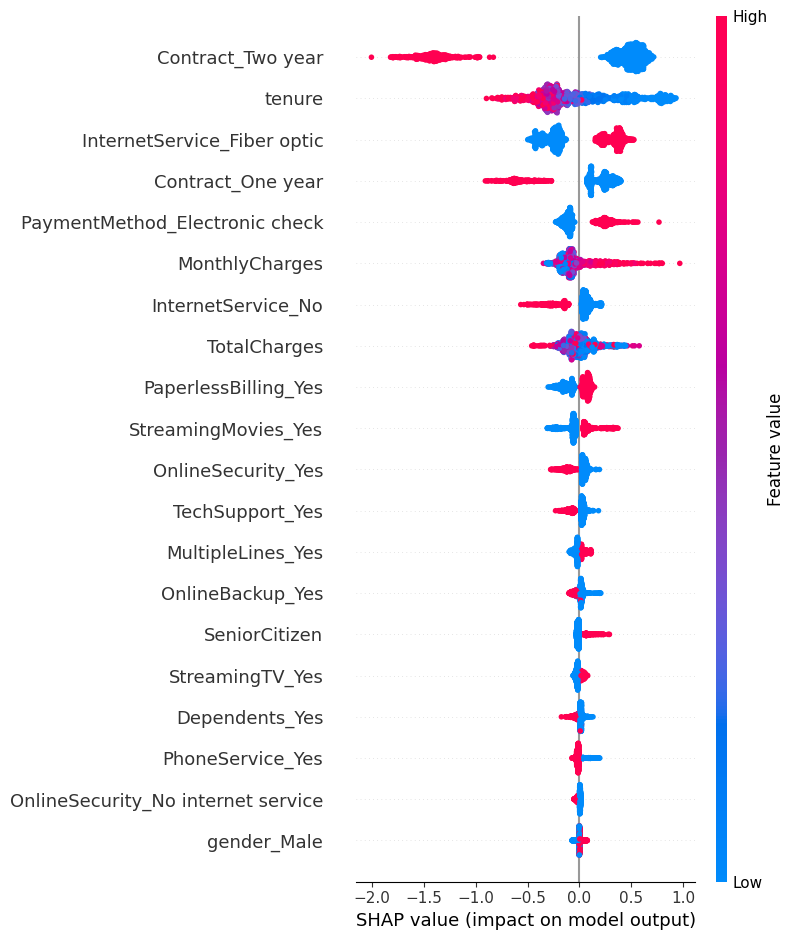

In [28]:
shap.summary_plot(shap_values, X_test)


## SHAP Feature Importance (Bar Plot)

This plot shows mean absolute SHAP values,
providing a clear ranking of feature importance.


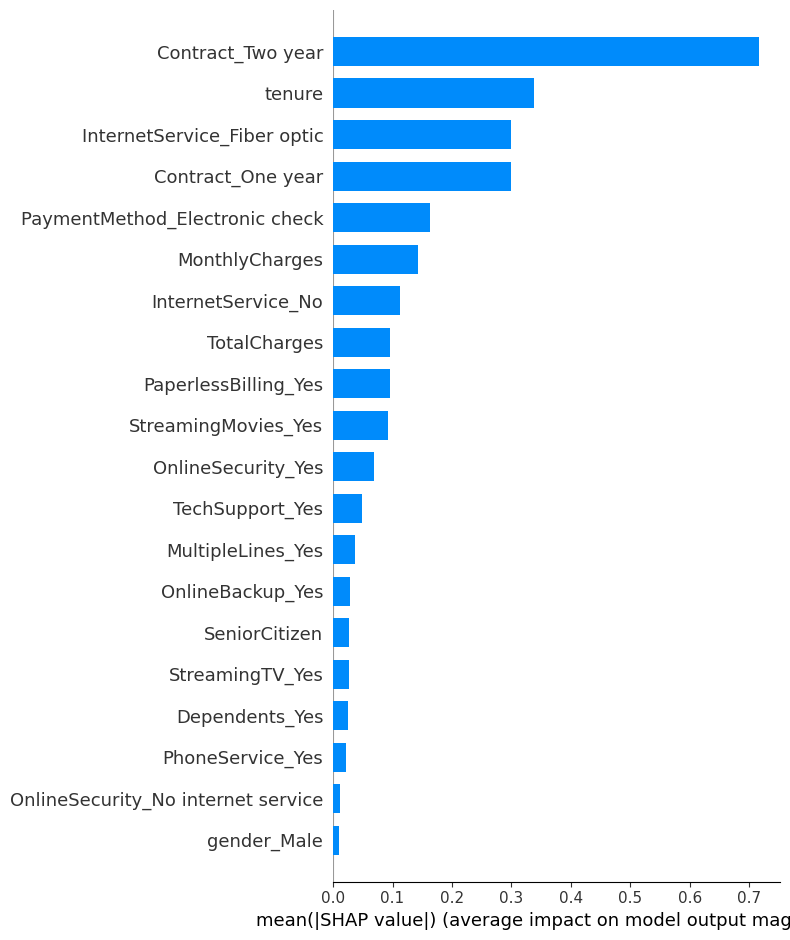

In [29]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


## Comparison: SHAP vs LightGBM Native Importance

We now compare:
- LightGBM’s internal feature importance
- SHAP-based feature importance

SHAP is generally more reliable because:
- It measures actual contribution to predictions
- It considers interaction effects
- It is consistent and theoretically grounded


In [31]:
shap_importance = pd.DataFrame({
    "Feature": X.columns,
    "SHAP_Importance": np.abs(shap_values.values).mean(axis=0)
}).sort_values(by="SHAP_Importance", ascending=False)

shap_importance.head(10)


,Feature,SHAP_Importance
25,Contract_Two year,0.715791
1,tenure,0.337236
10,InternetService_Fiber optic,0.299917
24,Contract_One year,0.298481
28,PaymentMethod_Electronic check,0.163565
2,MonthlyCharges,0.142702
11,InternetService_No,0.112701
3,TotalCharges,0.095994
26,PaperlessBilling_Yes,0.094898
23,StreamingMovies_Yes,0.093099


## Interpretation of SHAP Results

From the SHAP summary plot, we observe:

1. Contract type is one of the strongest predictors of churn.
   Customers with month-to-month contracts are more likely to churn.

2. MonthlyCharges has a strong positive relationship with churn.
   Higher monthly charges push predictions toward churn.

3. Tenure has a negative relationship with churn.
   Customers with longer tenure are less likely to churn.

Compared to LightGBM’s native importance:
- SHAP provides clearer directional insights.
- Some features ranked lower in LightGBM appear more influential in SHAP.

This confirms that SHAP gives deeper interpretability beyond simple feature counts.


In [32]:
# Get predictions
y_pred = best_model.predict(X_test)

# Find correctly classified example
correct_index = np.where(y_pred == y_test)[0][0]

# Find incorrectly classified example
incorrect_index = np.where(y_pred != y_test)[0][0]

correct_index, incorrect_index


(np.int64(0), np.int64(1))

# SHAP Force Plot Analysis

The force plot shows how each feature contributes to an individual prediction.

Red → pushes prediction toward churn  
Blue → pushes prediction toward non-churn  

We analyze:
1. A correctly classified prediction
2. An incorrectly classified prediction


In [33]:
shap.plots.force(
    shap_values[correct_index]
)


In [34]:
shap.plots.force(
    shap_values[incorrect_index]
)


# SHAP Waterfall Plot

The waterfall plot visualizes:

- Starting base value
- Each feature’s additive contribution
- Final predicted probability

This makes feature impact clearer than the force plot.


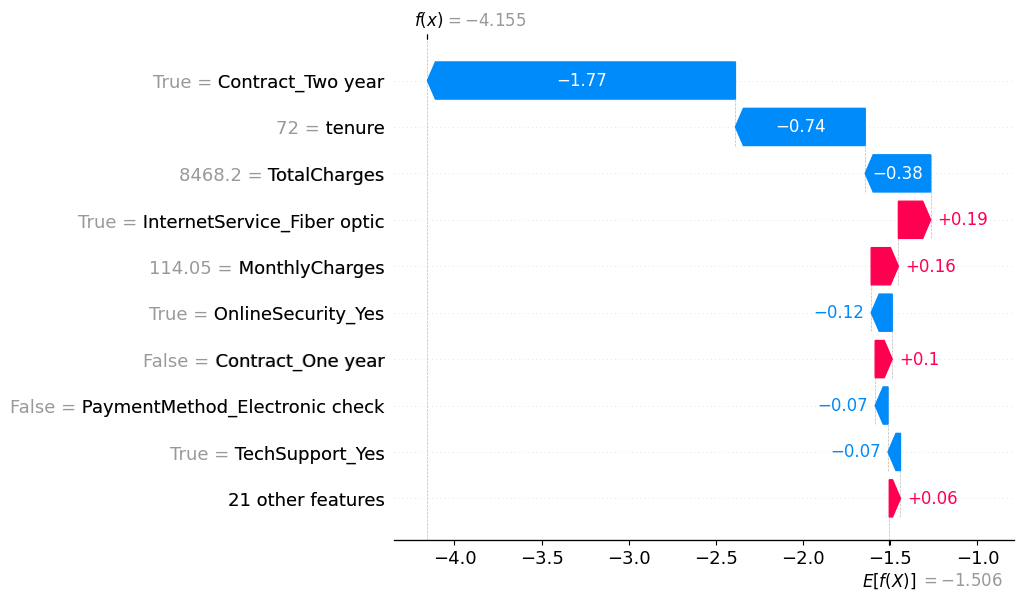

In [35]:
shap.plots.waterfall(shap_values[correct_index])


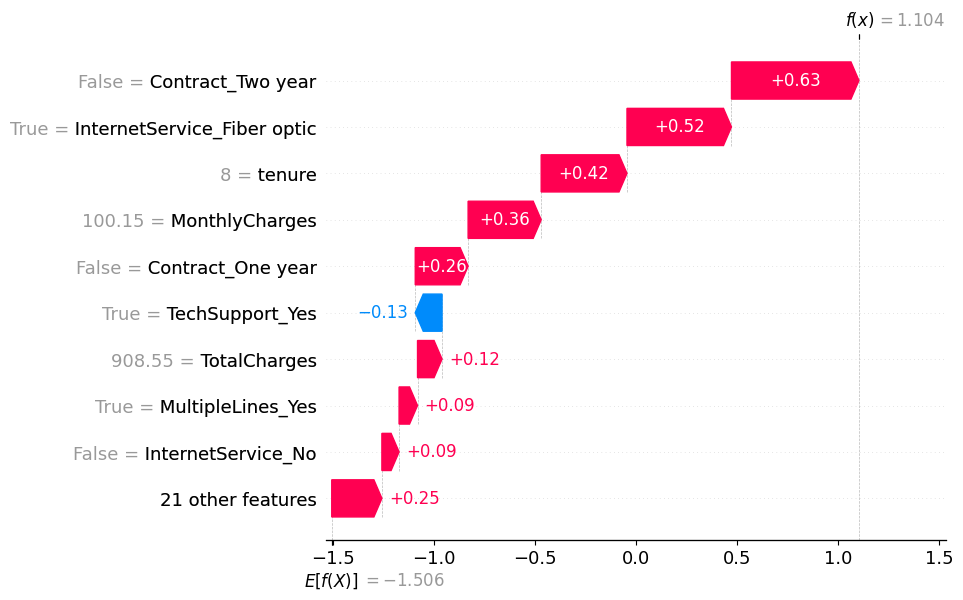

In [36]:
shap.plots.waterfall(shap_values[incorrect_index])


# Local Prediction Interpretation

## Correct Prediction

In the correctly classified case:
- High monthly charges pushed prediction toward churn.
- Short tenure increased churn probability.
- Contract type (month-to-month) strongly contributed positively.

These combined effects resulted in a high churn prediction,
which matched the actual label.

---

## Incorrect Prediction

In the misclassified case:
- Some features pushed toward churn.
- However, strong negative contributions (e.g., long tenure)
  outweighed them.

The model may struggle in borderline cases where feature
signals conflict.

This analysis demonstrates how SHAP helps diagnose
model errors at an individual level.


# SHAP Dependence Plots

Dependence plots show:

- Relationship between feature value and SHAP value
- Interaction with other features
- Non-linear patterns


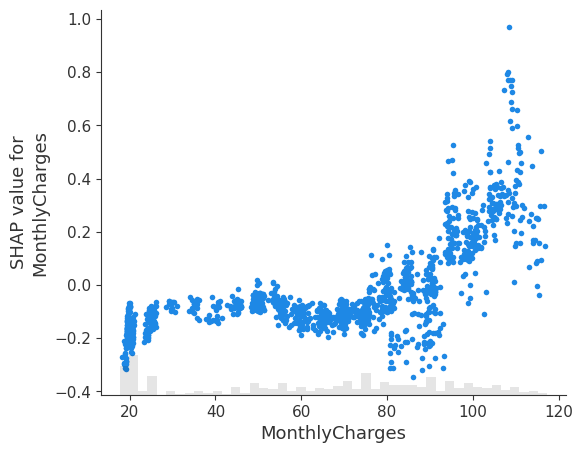

In [37]:
shap.plots.scatter(
    shap_values[:, "MonthlyCharges"]
)


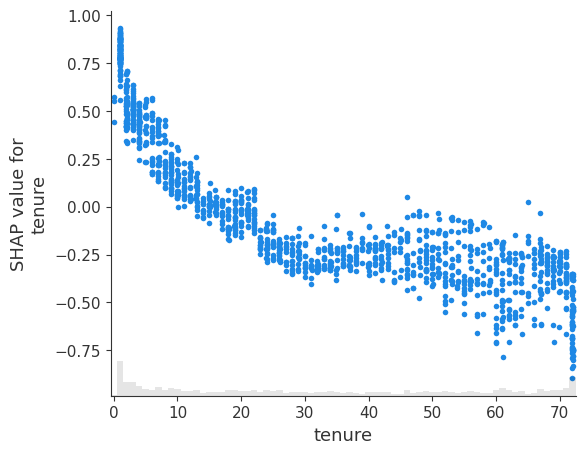

In [38]:
shap.plots.scatter(
    shap_values[:, "tenure"]
)


# Feature Interaction Insights

## MonthlyCharges

Higher monthly charges generally increase churn probability.
The relationship appears non-linear, with sharper increases
beyond certain thresholds.

## Tenure

Longer tenure strongly reduces churn probability.
Customers with short tenure are much more volatile.

These patterns confirm business intuition:
- New customers are riskier.
- Expensive plans increase churn likelihood.


# Final Business Insights

Based on SHAP global and local analysis, we derive the following actionable insights:

---

## 1. Month-to-Month Contracts Drive High Churn

Customers on month-to-month contracts show the strongest positive SHAP values toward churn.

Business Action:
- Offer incentives to convert month-to-month customers to longer contracts.
- Provide loyalty discounts after 6 months.

---

## 2. High Monthly Charges Increase Churn Risk

Customers with higher monthly charges are more likely to churn.

Business Action:
- Int


# Conclusion

This project developed a LightGBM-based churn prediction model achieving an ROC-AUC of 0.84.

Using SHAP, we analyzed the model at:

- Global level (feature importance and distribution)
- Local level (individual prediction explanations)
- Interaction level (feature dependence relationships)

SHAP provided transparent explanations of model decisions,
building trust and enabling actionable business strategies.

This approach demonstrates how machine learning models
can move beyond black-box predictions into explainable AI systems.
